In [1]:
#!pip install torch --quiet
#!pip install gpytorch --quiet

In [128]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import math
#import torch
#import gpytorch
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
import sklearn.gaussian_process as gp
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel, ConstantKernel, Matern

In [129]:
training_data = pd.read_csv('../../data/2-uw_layer1_trainingdata.csv')
#training_data = pd.read_csv('../../data/2.1-seattle_layer1_trainingdata.csv')

In [130]:
training_data.head()

,BOREHOLE_ID,BOREHOLE_NAME,BOREHOLE_TYPE,BOREHOLE_DEPTH_FT,ELEVATION_FT,LATITUDE,LONGITUDE,LAYER_NUMBER,TOP_DEPTH_FT,BOTTOM_DEPTH_FT,USCS,SIMPLE_USCS,LAYER_THICKNESS_FT,geometry,MAPPED_UNIT,SLOPE,ROUGHNESS
0,7138,B-1,Geotechnical,20.3,167.8,47.656719,-122.305728,1,0.0,1.0,SP,S,1.0,POINT (-122.30572826225551 47.65671910427262),Qvt,3.668571,18.199593
1,7143,B-1-92,Geotechnical,48.5,123.2,47.653642,-122.306837,1,0.0,1.0,ML,M,1.0,POINT (-122.30683733651996 47.653641992071),Qvt,2.222722,10.232103
2,7144,B-2-92,Geotechnical,42.5,122.9,47.653766,-122.306468,1,0.0,1.0,ML,M,1.0,POINT (-122.30646818846918 47.653765607387086),Qvt,1.996012,9.385303
3,7145,B-3-92,Geotechnical,43.0,117.3,47.653256,-122.306638,1,0.0,1.0,ML,M,1.0,POINT (-122.30663757111256 47.65325573559402),Qvt,3.011285,14.187020
4,7146,B-4-92,Geotechnical,43.0,123.4,47.653709,-122.306259,1,0.0,0.5,SM,S,0.5,POINT (-122.30625929325416 47.65370851868135),Qvt,1.996012,9.385303


<Axes: >

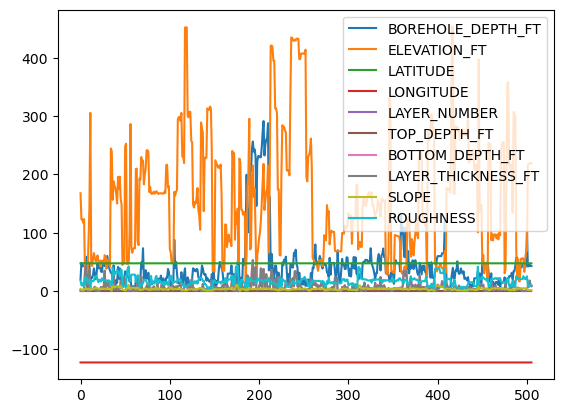

In [131]:
training_data.drop(columns=['BOREHOLE_ID']).plot()

In [132]:
#training_data.boxplot(column='LAYER_THICKNESS_FT', by='USCS')

In [133]:
#training_data.boxplot(column='SLOPE', by='USCS')

In [134]:
#training_data.boxplot(column='ROUGHNESS', by='USCS')

In [135]:
#training_data.boxplot(column='LAYER_THICKNESS_FT', by='SIMPLE_USCS')

In [136]:
#training_data.boxplot(column='SLOPE', by='SIMPLE_USCS')

In [137]:
#training_data.boxplot(column='ROUGHNESS', by='SIMPLE_USCS')

one-hot-encoding for MAPPED_UNIT feature

In [138]:
# with sklearn function
#enc = OneHotEncoder(handle_unknown='ignore')
#encoded_mapped_unit = enc.fit_transform(training_data[['MAPPED_UNIT']]).toarray()


In [139]:
## Preprocessing
#preprocessor = ColumnTransformer(
#    transformers=[
#        ('cat', OneHotEncoder(), ['MAPPED_UNIT']),  # One-hot encode categorical features
#        ('num', StandardScaler(), ['SLOPE', 'ROUGHNESS'])  # Standardize numerical features
#    ])
#
## Apply transformations and convert to dense array
#training_data_processed = preprocessor.fit_transform(training_data).toarray()  # Convert to array if sparse

In [140]:
#training_data.keys()

In [141]:
#training_data_processed = pd.DataFrame(training_data_processed)

In [142]:
#training_data_processed

In [143]:
# for the classification model
#X_c = training_data_processed.drop(columns=[11,12])
#y_c = training_data_processed['SIMPLE_USCS']

## for the regression model
#X_r = training_data_encoded.drop(columns=['BOREHOLE_ID', 'BOREHOLE_NAME', 'BOREHOLE_TYPE', 'BOREHOLE_DEPTH_FT',
#       'ELEVATION_FT', 'LATITUDE', 'LONGITUDE', 'LAYER_NUMBER', 'TOP_DEPTH_FT',
#       'BOTTOM_DEPTH_FT', 'SIMPLE_USCS', 'USCS', 'LAYER_THICKNESS_FT',
#       'geometry'])
#y_r = training_data_encoded['LAYER_THICKNESS_FT']

In [144]:
# with pandas, seems simpler
training_data_encoded = pd.get_dummies(training_data, columns = ['MAPPED_UNIT'], dtype=int)

# scalers
slope_scaler = StandardScaler()
roughness_scaler = StandardScaler()
elevation_scaler = StandardScaler()
latitude_scaler = StandardScaler()
longitude_scaler = StandardScaler()
layer_thickness_scaler = StandardScaler()

# scaling features
training_data_encoded['SLOPE'] = slope_scaler.fit_transform(pd.DataFrame(training_data_encoded['SLOPE']))
training_data_encoded['ROUGHNESS'] = roughness_scaler.fit_transform(pd.DataFrame(training_data_encoded['ROUGHNESS']))
training_data_encoded['ELEVATION_FT'] = elevation_scaler.fit_transform(pd.DataFrame(training_data_encoded['ELEVATION_FT']))
training_data_encoded['LATITUDE'] = latitude_scaler.fit_transform(pd.DataFrame(training_data_encoded['LATITUDE']))
training_data_encoded['LONGITUDE'] = longitude_scaler.fit_transform(pd.DataFrame(training_data_encoded['LONGITUDE']))

# scaling target
training_data_encoded['LAYER_THICKNESS_FT'] = layer_thickness_scaler.fit_transform(pd.DataFrame(training_data_encoded['LAYER_THICKNESS_FT']))



# labeler for target
#simple_uscs_encoder = LabelEncoder()
#
#training_data_encoded['SIMPLE_USCS'] = simple_uscs_encoder.fit(training_data_encoded['SIMPLE_USCS']).transform(training_data_encoded['SIMPLE_USCS'])
#print(simple_uscs_encoder.classes_)

In [145]:
training_data_encoded.head()

,BOREHOLE_ID,BOREHOLE_NAME,BOREHOLE_TYPE,BOREHOLE_DEPTH_FT,ELEVATION_FT,LATITUDE,LONGITUDE,LAYER_NUMBER,TOP_DEPTH_FT,BOTTOM_DEPTH_FT,...,MAPPED_UNIT_Ql,MAPPED_UNIT_Qp,MAPPED_UNIT_Qpf,MAPPED_UNIT_Qpo,MAPPED_UNIT_Qva,MAPPED_UNIT_Qvi,MAPPED_UNIT_Qvr,MAPPED_UNIT_Qvt,MAPPED_UNIT_Qw,MAPPED_UNIT_wtr
0,7138,B-1,Geotechnical,20.3,0.057875,-0.565928,0.899960,1,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0
1,7143,B-1-92,Geotechnical,48.5,-0.371846,-0.758805,0.817198,1,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0
2,7144,B-2-92,Geotechnical,42.5,-0.374737,-0.751057,0.844744,1,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0
3,7145,B-3-92,Geotechnical,43.0,-0.428693,-0.783017,0.832105,1,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0
4,7146,B-4-92,Geotechnical,43.0,-0.369919,-0.754635,0.860333,1,0.0,0.5,...,0,0,0,0,0,0,0,1,0,0


In [146]:
training_data_encoded.dropna(inplace=True)

GPC

In [245]:
# for the classification model
X_c = training_data_encoded.drop(columns=['BOREHOLE_ID', 'BOREHOLE_NAME', 'BOREHOLE_TYPE', 'BOREHOLE_DEPTH_FT',
       #'ELEVATION_FT', 'LATITUDE', 'LONGITUDE', 
       'LAYER_NUMBER', 'TOP_DEPTH_FT',
       'BOTTOM_DEPTH_FT', 'SIMPLE_USCS', 'USCS', 'LAYER_THICKNESS_FT',
       'geometry'])
y_c = training_data_encoded['SIMPLE_USCS']



In [265]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.2, random_state=42)

In [266]:
print('Features:')
_ = [print('\t', feature) for feature in X_train_c.keys()]

print('Target:')
print('\t', y_train_c.name)

Features:
	 ELEVATION_FT
	 LATITUDE
	 LONGITUDE
	 SLOPE
	 ROUGHNESS
	 MAPPED_UNIT_Qal
	 MAPPED_UNIT_Ql
	 MAPPED_UNIT_Qp
	 MAPPED_UNIT_Qpf
	 MAPPED_UNIT_Qpo
	 MAPPED_UNIT_Qva
	 MAPPED_UNIT_Qvi
	 MAPPED_UNIT_Qvr
	 MAPPED_UNIT_Qvt
	 MAPPED_UNIT_Qw
	 MAPPED_UNIT_wtr
Target:
	 SIMPLE_USCS


In [267]:
kernel_c = ConstantKernel(constant_value=1) * \
            RBF(length_scale=5.0, length_scale_bounds=(1e-5, 1e5)) #* \
            #WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-05, 1e5))
#kernel_c = Matern(length_scale=1e-5, length_scale_bounds=(1e-5, 1e8), nu=1.5)

In [276]:
myGPC = gp.GaussianProcessClassifier(kernel=kernel_c, multi_class='one_vs_rest')
myGPC

GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=5))

In [277]:
myGPC.fit(X_train_c, y_train_c)

GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=5))

In [278]:
y_train_c

477    S
15     S
332    S
423    M
19     G
      ..
106    S
270    S
348    M
435    S
102    M
Name: SIMPLE_USCS, Length: 404, dtype: object

In [279]:
myGPC.n_classes_

6

In [280]:
myGPC.classes_

array(['C', 'G', 'M', 'O', 'P', 'S'], dtype=object)

In [281]:
y_predicted_c = myGPC.predict(X_test_c)

In [282]:
y_predicted_c

array(['S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S',
       'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S',
       'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S',
       'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S',
       'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S',
       'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S',
       'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S',
       'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S'], dtype='<U1')

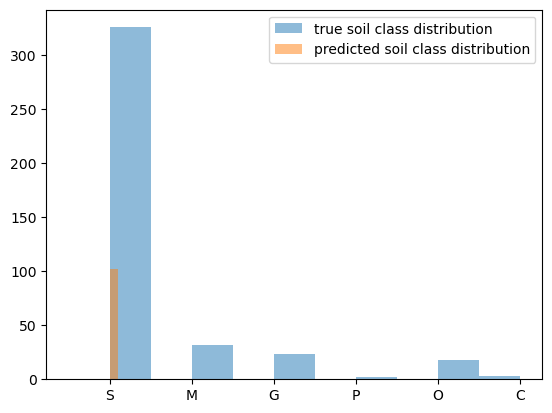

In [283]:
plt.figure()
plt.hist(y_train_c, alpha=0.5, label='true soil class distribution')
plt.hist(y_predicted_c, alpha=0.5, label='predicted soil class distribution')
plt.legend()

In [297]:
n_classes = []
n_classes_true = []

lengths = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7]

for length in lengths:
    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.2)
    kernel_c = ConstantKernel(constant_value=1) * \
                RBF(length_scale=length, length_scale_bounds=(1e-5, 1e5))
    myGPC = gp.GaussianProcessClassifier(kernel=kernel_c, multi_class='one_vs_rest')
    myGPC.fit(X_train_c, y_train_c)
    y_predicted_c = myGPC.predict(X_test_c)

    n_classes_true.append(len(np.unique(y_test_c)))
    n_classes.append(len(np.unique(y_predicted_c)))

/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-p

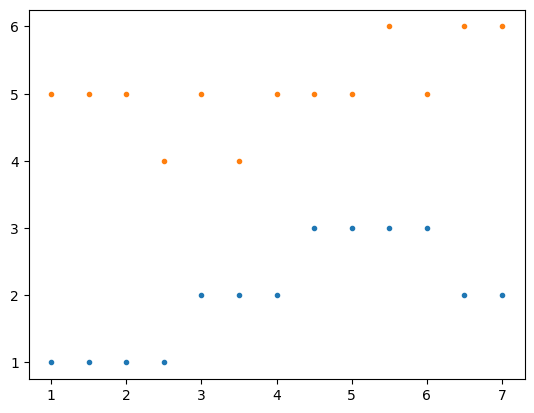

In [298]:
plt.plot(np.array(lengths), np.array(n_classes), '.')
plt.plot(np.array(lengths), np.array(n_classes_true), '.')

In [294]:
np.array(n_classes_true)

array([5, 5, 5, 5, 5, 5])

GPR

In [161]:
# for the regression model
X_r = training_data_encoded.drop(columns=['BOREHOLE_ID', 'BOREHOLE_NAME', 'BOREHOLE_TYPE', 'BOREHOLE_DEPTH_FT',
       'ELEVATION_FT', 'LATITUDE', 'LONGITUDE', 
       'LAYER_NUMBER', 'TOP_DEPTH_FT',
       'BOTTOM_DEPTH_FT', 'SIMPLE_USCS', 'USCS', 'LAYER_THICKNESS_FT',
       'geometry'])
y_r = training_data_encoded['LAYER_THICKNESS_FT']

In [162]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_r, y_r, test_size=0.2, random_state=42)


In [163]:
print('Features:')
_ = [print('\t', feature) for feature in X_train_r.keys()]

print('Target:')
print('\t', y_train_r.name)

Features:
	 SLOPE
	 ROUGHNESS
	 MAPPED_UNIT_Qal
	 MAPPED_UNIT_Ql
	 MAPPED_UNIT_Qp
	 MAPPED_UNIT_Qpf
	 MAPPED_UNIT_Qpo
	 MAPPED_UNIT_Qva
	 MAPPED_UNIT_Qvi
	 MAPPED_UNIT_Qvr
	 MAPPED_UNIT_Qvt
	 MAPPED_UNIT_Qw
	 MAPPED_UNIT_wtr
Target:
	 LAYER_THICKNESS_FT


In [240]:
kernel_r = ConstantKernel(constant_value=1.0) * RBF(length_scale=1.0, length_scale_bounds=(1e2,1e7))

In [241]:
myGPR = gp.GaussianProcessRegressor(kernel=kernel_r)


In [242]:
myGPR.fit(X_train_r, y_train_r)

/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1))

In [243]:
y_predicted_r = myGPR.predict(X_test_r)

In [244]:
y_test_r.shape

(102,)

Inverse transform back into layer thickness in feet to look at predictions and errors

In [245]:
predicted_thickness_ft = layer_thickness_scaler.inverse_transform(pd.DataFrame(y_predicted_r))
true_thickness_ft = layer_thickness_scaler.inverse_transform(pd.DataFrame(y_test_r))

(array([ 5., 36., 29., 11.,  9.,  2.,  3.,  2.,  2.,  3.]),
 array([-10.40089836,  -6.70962917,  -3.01835997,   0.67290923,
          4.36417842,   8.05544762,  11.74671682,  15.43798601,
         19.12925521,  22.82052441,  26.51179361]),
 <BarContainer object of 10 artists>)

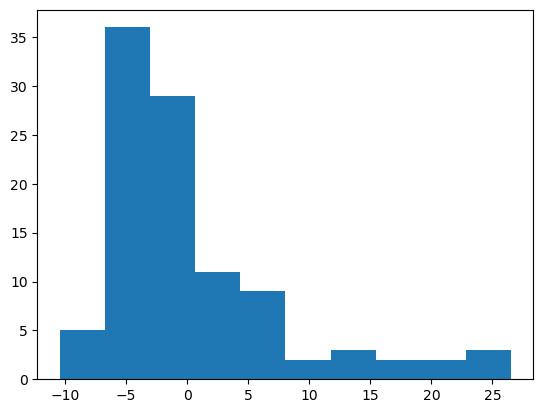

In [246]:
residuals = true_thickness_ft-predicted_thickness_ft
plt.hist(residuals)

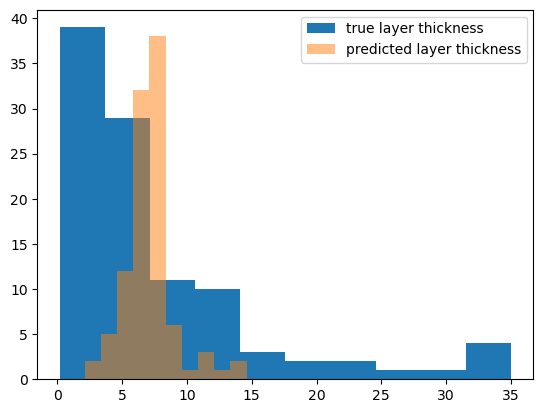

In [247]:
plt.hist(true_thickness_ft, label='true layer thickness')
plt.hist(predicted_thickness_ft,alpha=0.5, label='predicted layer thickness')
plt.legend()

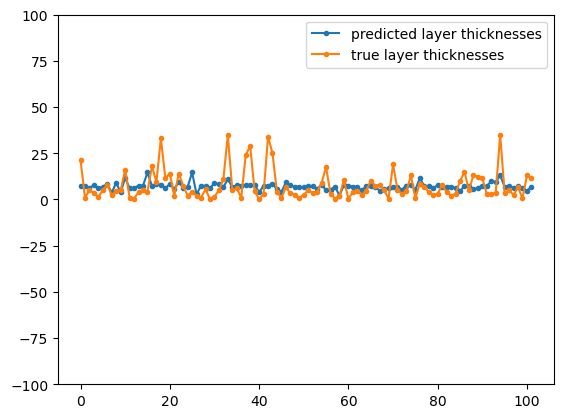

In [248]:
plt.plot(predicted_thickness_ft, '.-', label='predicted layer thicknesses')
plt.plot(true_thickness_ft,'.-', label='true layer thicknesses')
plt.ylim(-100,100)
plt.legend()

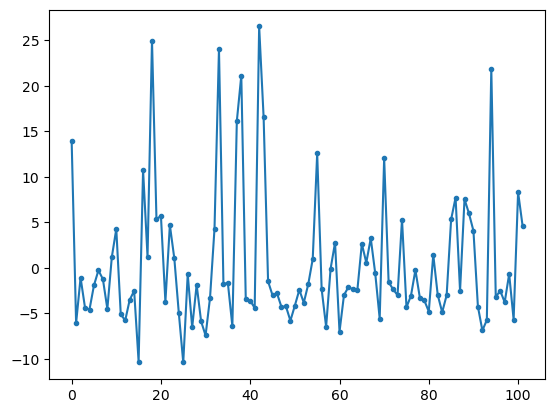

In [250]:
plt.plot(residuals, '.-');
